In [313]:
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
import time

import properties as prop
import random_initialization as rand_init
import matrixes as ma
import interblock_matrixes as i_ma
import utils as u
import reservoir as res
import matrix_initialization as ma_init

imp.reload(prop)
imp.reload(rand_init)
imp.reload(ma)
imp.reload(i_ma)
imp.reload(u)
imp.reload(res)
imp.reload(ma_init)

const = prop.Constants()

In [314]:
nx , ny = 20, 1

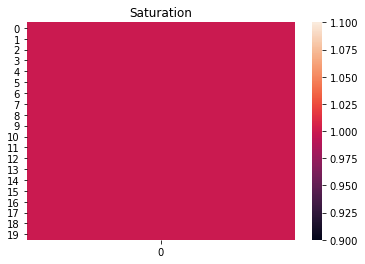

In [315]:
Satur_matrix = np.ones((nx, ny))  # ma_init.get_matrix_with_pdf(nx=nx, ny=ny, pdf=ma_init.corner)
Satur_matrix *= 1
sns.heatmap(Satur_matrix)
plt.title("Saturation")
plt.show()

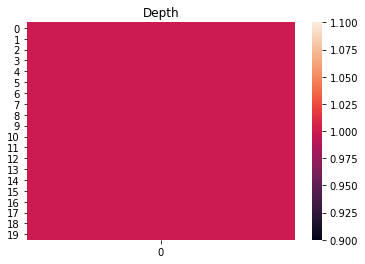

In [316]:
depth_matrix = np.ones((nx, ny))  # ma_init.get_matrix_with_pdf(nx=nx, ny=ny, pdf=ma_init.centroid)
sns.heatmap(depth_matrix)
plt.title("Depth")
plt.show()

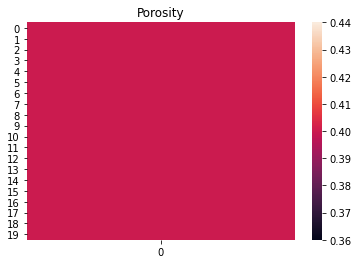

In [317]:
porosity_matrix = np.ones((nx, ny))  # ma_init.get_matrix_with_pdf(nx=nx, ny=ny, pdf=ma_init.centroid)
porosity_matrix *= 0.4
sns.heatmap(porosity_matrix)
plt.title("Porosity")
plt.show()

$poirosity\leq 40\%$

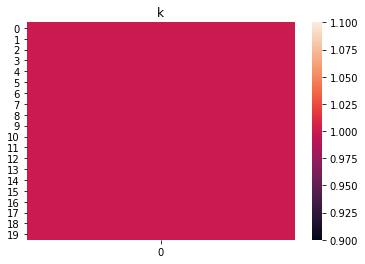

In [318]:
k_matrix = np.ones((nx, ny))  # ma_init.get_matrix_with_pdf(nx=nx, ny=ny, pdf=ma_init.corner_1)
sns.heatmap(k_matrix)
plt.title("k")
plt.show()

Давления пусть будут одинаково распределены

In [319]:
dy = np.ones(ny) * const.dy()
dx = np.ones(nx) * const.dx()

p_vec = np.ones((nx*ny)).reshape((-1, 1)) * const.p_0()
S_o_vec = Satur_matrix.reshape((-1, 1))
S_w_vec = (np.ones(Satur_matrix.shape) - Satur_matrix).reshape((-1, 1))

Обозначем важные прмежуточные матрицы для 
$$\vec{p^{n+1}} = \vec{p^{n}} + \Delta t \big[B^{p, w}\big]^{-1}\big[ T^{upd}_{\tilde{k}} \vec{p} + \tilde{Q} + \frac{B_o}{B_w} q_o^{well} + q_w^{well}\big]$$

In [320]:
wells = {(15, 0): 0
        }
neibours = [(2, 0)]

In [321]:
env = res.Env(k_2d_matrix=k_matrix, poir_2d_matrix=porosity_matrix, depth_2d_matrix=depth_matrix,
              satur_2d_matrix=Satur_matrix,
              const=const, well_positions=wells,
              boundary_cond = 'const_pressure',
              two_d_well_index_rw_scale={}
             )

In [322]:
def accurate_solution(t, n, const, L, alpha, x):
    out = 0.
    out += const.p_b()
    adj = 0.
    for k in range(1, n+1):
        adj -= 2. * np.exp((-1. * np.pi * np.pi * t * k * k) / (L * L * alpha))
        adj *= (const.p_b() - const.p_0()) * (1. + (-1) ** (k + 1))
        adj *= np.sin(np.pi * x * k / L)
        adj /= np.pi
        adj /= k
        out += adj
    return out / const.p_0()

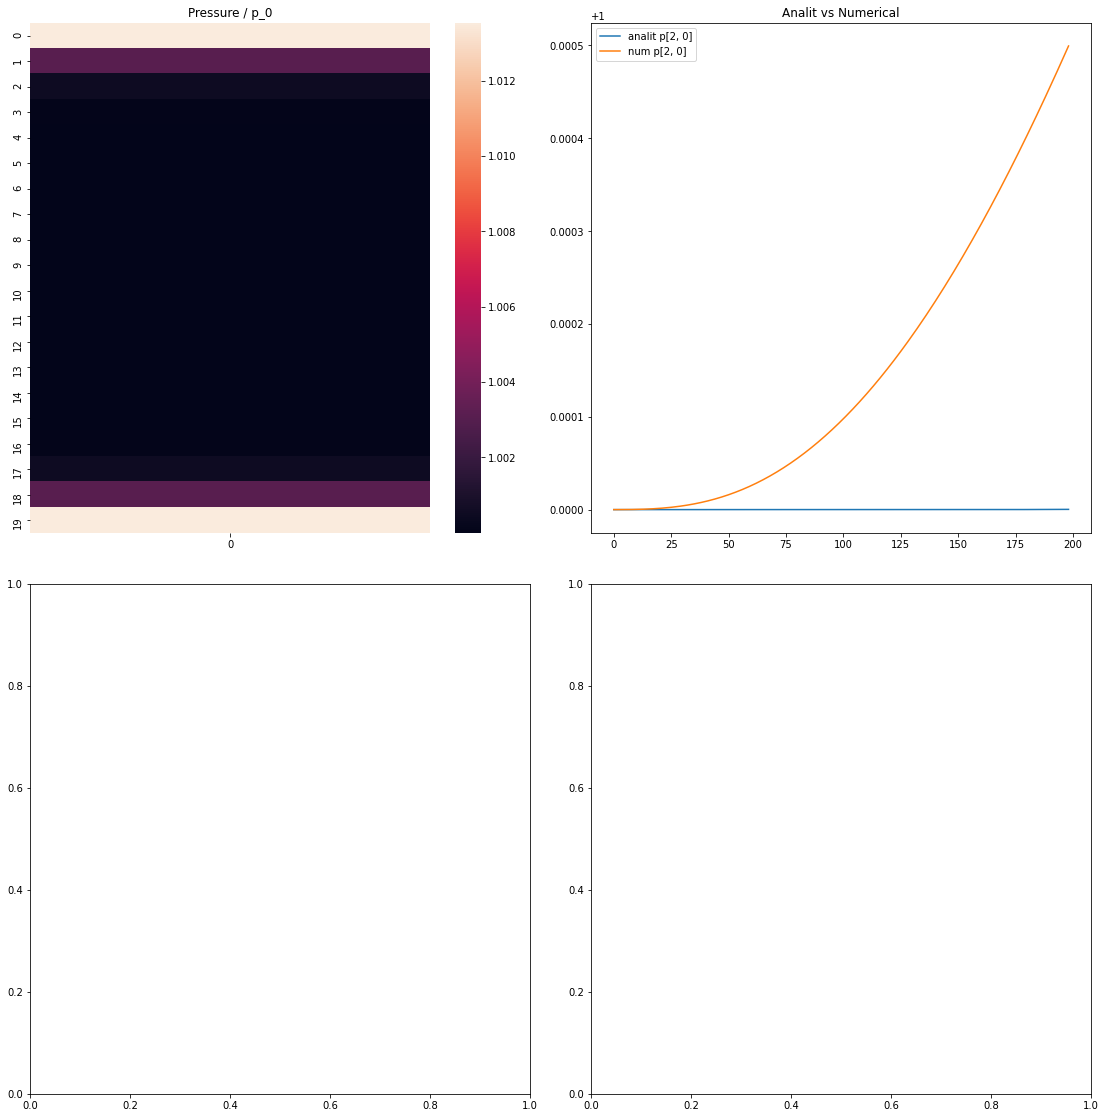

In [323]:
n_it = int(2e2)
upd_plot_freq = int(1e0)

p_hist_analit = {key: [] for key in neibours}
p_hist_num = {key: [] for key in neibours}

for i in range(1, n_it):
    env.step()
    env.set_saturation_oil(Satur_matrix)
    
    if i % upd_plot_freq == 0:
        
        p = env.p_as_2d()
        
        for key in neibours:
            p_hist_analit[key].append(accurate_solution(t=i * const.dt(), n=1000, const=const, L=nx*const.dx(),
                                                        alpha=19.29, x=const.dx()*key[0]
                                                       )
                                     )
            p_hist_num[key].append(p[key[0], key[1]] / const.p_0())
        
        display.clear_output(wait=True)
        f, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
        f.tight_layout(pad=3.0)
        g1 = sns.heatmap(env.p_as_2d() / const.p_0(), ax=ax[0][0], cbar=True) #, vmax=1, vmin=0.8)
        g1.set_title('Pressure / p_0')
        
        for key in neibours:
            ax[0][1].plot(p_hist_analit[key], label=f'analit p[{key[0]}, {key[1]}]')
            ax[0][1].plot(p_hist_num[key], label=f'num p[{key[0]}, {key[1]}]')
            ax[0][1].set_title(f'Analit vs Numerical')
        ax[0][1].legend()
        
        plt.show()

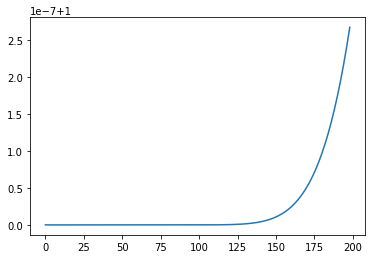

In [324]:
plt.plot(p_hist_analit[(2, 0)])